# Dynamic Analysis
#### Author: Orlando Arroyo
#### email: odarroyo@uc.cl

## Loading libraries

In [1]:
from openseespy.opensees import *
import opsvis as opsv # load opsvis for model visualization
import matplotlib.pyplot as plt # the standard plotting library
import opseestools.analisis as an # loading the 2D analysis module of opseestools 
import opseestools.utilidades as ut # loading the third module (utilidades) of opseestools
import numpy as np # loading numpy library

## Model creation

In [2]:
wipe() 
model('basic','-ndm',2,'-ndf',3) 

## Defining nodes and support conditions

<Axes: >

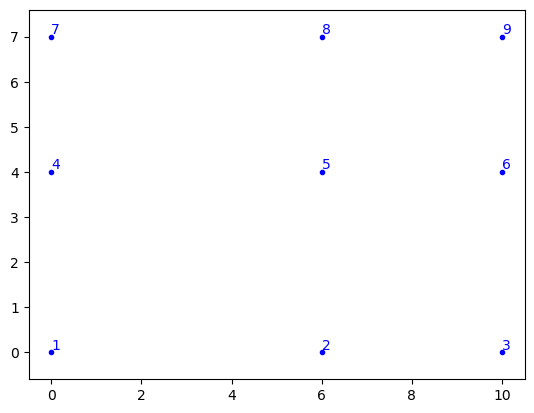

In [3]:
x1 = 6.0
x2 = 10.0
y1 = 4.0
y2 = 7.0

node(1,0.0,0.0)
node(2,x1,0.0)
node(3,x2,0.0)
node(4,0.0,y1)
node(5,x1,y1)
node(6,x2,y1)
node(7,0.0,y2)
node(8,x1,y2)
node(9,x2,y2)

# supports
empotrado = [1,1,1] # fix all degrees
grado2 = [1,1,0] # 

fix(1,*empotrado)
fix(2,*empotrado)
fix(3,*empotrado)

# Visualización de los nodos
opsv.plot_model()

## Defining diaphragms and masses

In [4]:
# diafragmas
equalDOF(4,5,1) 
equalDOF(4,6,1)
equalDOF(7,8,1) 
equalDOF(7,9,1)

# masas
mass(4,1,1,0) 
mass(5,1,1,0)
mass(6,1,1,0)
mass(7,1,1,0)
mass(8,1,1,0)
mass(9,1,1,0)

## Material definition

In [5]:

E = 24000000.0
fc = 28000.0
ec = 2*fc/E
fcu = 0.2*fc
ecu = 0.006

# Para el concreto confinado
k=1.3
fcc=28000.0*k
ecc= 2*fcc/E
fucc=0.2*fcc
eucc=0.02

# Para el acero
Fy=420000.0
Es=210000000.0

uniaxialMaterial('Concrete01', 2, fc, ec, fcu, ecu)
uniaxialMaterial('Concrete01', 1, fcc, ecc, fucc, eucc)
uniaxialMaterial('Steel01', 3, Fy, Es, 0.01)

## Creation of fiber section


In [6]:
# Fiber section
# 30 x 30 cm with 8 # 4

Bcol = 0.3
Hcol = 0.3
c = 0.05  # recubrimiento 

# creación de la sección de fibra
y1col = Hcol/2.0
z1col = Bcol/2.0

y2col = 0.5*(Hcol-2*c)/3.0

nFibZ = 1
nFibZcore= 10
nFib = 20
nFibCover, nFibCore = 8, 16
As4 = 0.000127
As5 = 0.0002
As7 = 0.000387

sec30x30 = 1 # column section

# Use of the BuildRCSection command 
ut.BuildRCSection(sec30x30, Hcol, Bcol, c, c, 1, 2, 3, 3, As4, 3, As4, 4, As4, nFibCore, nFibZcore, nFibCover, nFibCover)

# Five integration points with a Gauss-Lobatto integration scheme
pint = 5 # puntos de integración
beamIntegration('Lobatto', sec30x30, sec30x30,pint) # esquema de integración

## Element definition

<Axes: >

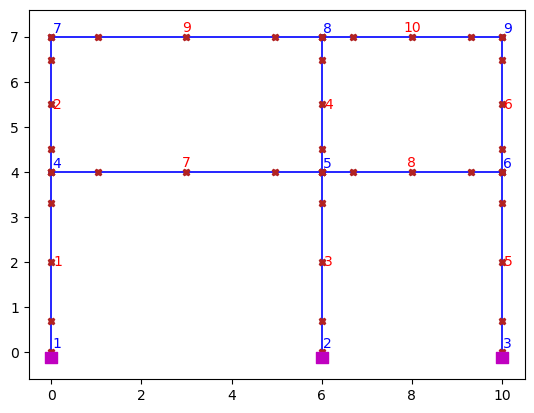

In [7]:
# Transformation
lineal = 1
geomTransf('Linear',lineal) # transformación lineal

pdelta = 2
geomTransf('PDelta',pdelta) # PDelta

# Columns
element('forceBeamColumn',1, 1,4 ,pdelta,sec30x30)
element('forceBeamColumn',2, 4,7 ,pdelta,sec30x30)
element('forceBeamColumn',3, 2,5 ,pdelta,sec30x30)
element('forceBeamColumn',4, 5,8 ,pdelta,sec30x30)
element('forceBeamColumn',5, 3,6 ,pdelta,sec30x30) 
element('forceBeamColumn',6, 6,9 ,pdelta,sec30x30) 

# Beams(for the example use the same section)
element('forceBeamColumn',7, 4,5 ,lineal,sec30x30)
element('forceBeamColumn',8, 5,6 ,lineal,sec30x30)
element('forceBeamColumn',9, 7,8 ,lineal,sec30x30) 
element('forceBeamColumn',10, 8,9 ,lineal,sec30x30) 

# para ver el modelo
opsv.plot_model()

## Model loads

In [8]:
timeSeries('Linear', 1)
pattern('Plain',1,1)
vigas = [7,8,9,10] 
wviga = 20
eleLoad('-ele',*vigas,'-type','beamUniform',-wviga) # aplicación de la carga sobre la viga

## Calculating first mode

Fundamental period is:  0.21760190401046586


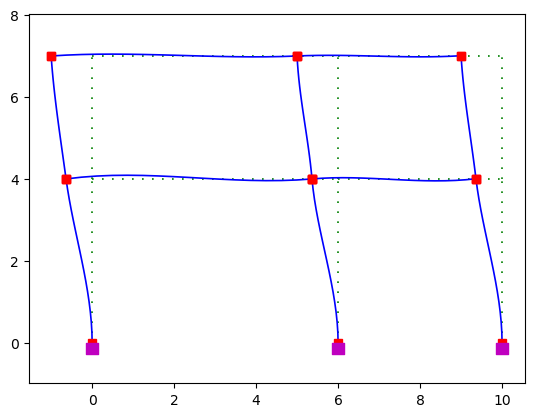

In [9]:
eig= eigen(1) # el comando eigen calcula las frecuencias de la cantidad de modos indicados. En este caso 1
T1 = 2*3.1416/np.sqrt(eig[0]) # Se obtiene el periodo correspondiente
print('Fundamental period is: ',T1) # Se imprime el resultado

# Visualización de la primera forma modal
opsv.plot_mode_shape(1)

## Análisis del modelo y representación de la deformada

201.63543985553568

<Figure size 640x480 with 0 Axes>

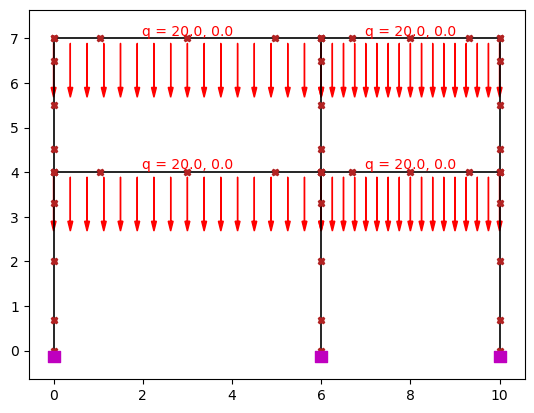

<Figure size 640x480 with 0 Axes>

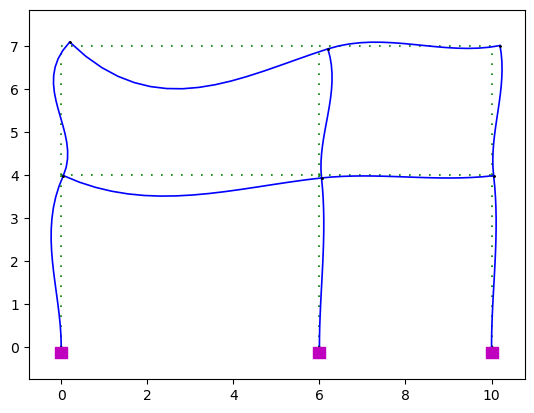

In [10]:
# Se usa la librería de análisis que se llamó

an.gravedad()
loadConst('-time',0.0) # este comando deja las cargas de gravedad fijas

# Representación del modelo con cargas
plt.figure()
opsv.plot_loads_2d()

# Representación de la deformada
plt.figure()
opsv.plot_defo()

## Dynamic Analysis

Using dinamicoIDA4P(recordName,dtrec,nPts,dtan,fact,damp,IDctrlNode,IDctrlDOF,elements,nodes_control), which requires:

1) recordName: name of the record txt file, for instance, 'GM01.txt'

2) dtrec: is the record time step

3) nPts: number of record points

4) dtan: time step for the analysis. Can be different from the record. 

5) fact: scale factor for the record. For instance, if the record units are in g, then you need to input gravity in units consistent with your model.

6) damp: damping ratio (IN DECIMAL. e.g: 0.03 for 3%)

7) IDcrtlNode node for control (typically roof node)

8) IDctrlDOF: DOF for node control, i.e., 1 for X, 2 for Y.

9) elements: list with the elements to record forces

10) nodes_control: one node per floor to compute displacements, acceleration, velocity and drifts. This fails if you enter more than one per floor.

Outputs are: time of analysis, roof displacement,element forces, nodes displacement, nodes velocity, nodes acceleration, drifts


In [11]:
tiempo,techo,Eds,node_disp,node_vel,node_acel,drift = an.dinamicoIDA4P('GM01.txt',0.01,3000,0.01,9.81,0.03,9,1,[1,3,5],[3,6,9])

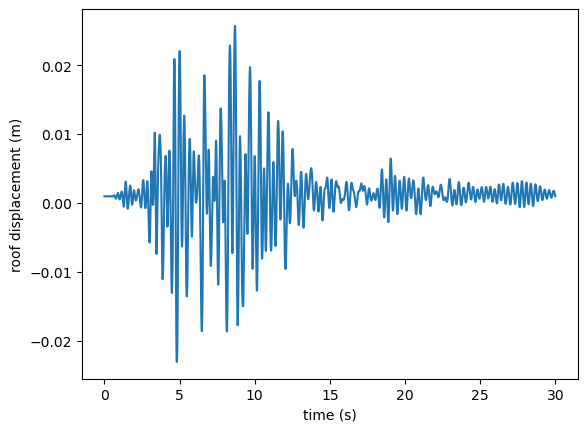

In [12]:
plt.plot(tiempo,techo)
plt.xlabel('time (s)')
plt.ylabel('roof displacement (m)')
plt.show()

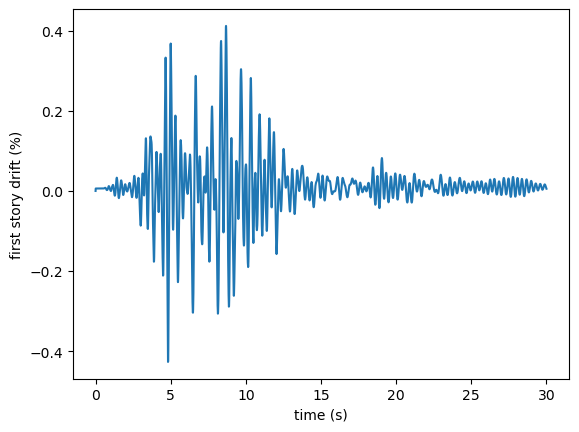

In [13]:
plt.plot(tiempo,drift[:,0]*100)
plt.xlabel('time (s)')
plt.ylabel('first story drift (%)')
plt.show()